# Entity and Relationship Extraction Statistics

This notebook analyzes and visualizes the statistics of extracted entities and relationships from threat intelligence data.

## Overview
- **Entity Analysis**: Count and distribution of different entity types
- **Relationship Analysis**: Count and distribution of relationship types
- **Performance Metrics**: Extraction performance across different models
- **Data Quality**: Analysis of extraction quality and completeness


In [6]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12


## 1. Load and Prepare Data


In [7]:
# Define data paths
DATA_DIR = Path('../data')
ENTITY_EXTRACTION_DIR = DATA_DIR / 'entity-extraction'
ENTITIES_DIR = DATA_DIR / 'entities'

# Load main extraction data
extraction_files = {
    'llama3': ENTITY_EXTRACTION_DIR / 'merged_llama3_extractions_full_content.json',
    'qwen3_14b': ENTITY_EXTRACTION_DIR / 'Qwen3-14B_2025-08-23_10-14-28_0_427.json'
}

def load_extraction_data(file_path):
    """Load and parse extraction data from JSON file"""
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        print(f"✅ Loaded {len(data)} records from {file_path.name}")
        return data
    except Exception as e:
        print(f"❌ Error loading {file_path}: {e}")
        return None

# Load all extraction data
extraction_data = {}
for model_name, file_path in extraction_files.items():
    if file_path.exists():
        extraction_data[model_name] = load_extraction_data(file_path)
    else:
        print(f"⚠️  File not found: {file_path}")


✅ Loaded 300 records from merged_llama3_extractions_full_content.json
✅ Loaded 427 records from Qwen3-14B_2025-08-23_10-14-28_0_427.json


In [8]:
# Load processed entity CSVs
entity_files = {
    'attackers': 'attackers.csv',
    'malware': 'malware.csv', 
    'tools': 'tools.csv',
    'vulnerabilities': 'vulnerabilities.csv',
    'files': 'files.csv',
    'hashes': 'hashes.csv'
}

entity_dataframes = {}
for entity_type, filename in entity_files.items():
    file_path = ENTITIES_DIR / filename
    if file_path.exists():
        df = pd.read_csv(file_path)
        entity_dataframes[entity_type] = df
        print(f"✅ Loaded {len(df)} {entity_type} entities")
    else:
        print(f"⚠️  Entity file not found: {filename}")

# Load relationships
relationships_file = DATA_DIR / 'relationships_norm.csv'
if relationships_file.exists():
    relationships_df = pd.read_csv(relationships_file)
    print(f"✅ Loaded {len(relationships_df)} relationships")
else:
    print(f"⚠️  Relationships file not found: {relationships_file}")


✅ Loaded 70 attackers entities
✅ Loaded 46 malware entities
✅ Loaded 121 tools entities
✅ Loaded 25 vulnerabilities entities
✅ Loaded 9 files entities
⚠️  Entity file not found: hashes.csv
⚠️  Relationships file not found: ../data/relationships_norm.csv


In [9]:
# Create comprehensive statistics table
print("📋 COMPREHENSIVE ENTITY EXTRACTION STATISTICS")
print("=" * 60)

# Processed entities summary
if entity_dataframes:
    print("\n🗂️  PROCESSED ENTITIES (From CSV Files):")
    processed_summary = []
    total_processed = 0
    
    for entity_type, df in entity_dataframes.items():
        count = len(df)
        total_processed += count
        unique_names = df['name'].nunique() if 'name' in df.columns else 'N/A'
        processed_summary.append({
            'Entity Type': entity_type.title(),
            'Total Count': f"{count:,}",
            'Unique Names': f"{unique_names:,}" if unique_names != 'N/A' else 'N/A'
        })
    
    processed_df = pd.DataFrame(processed_summary)
    print(processed_df.to_string(index=False))
    print(f"\n📊 TOTAL PROCESSED ENTITIES: {total_processed:,}")

# Relationships summary
if 'relationships_df' in locals():
    print("\n🔗 RELATIONSHIPS STATISTICS:")
    print(f"Total Relationships: {len(relationships_df):,}")
    print(f"Unique Relationship Types: {relationships_df['relation'].nunique()}")
    print(f"Unique Source Entities: {relationships_df['source_id'].nunique():,}")
    print(f"Unique Target Entities: {relationships_df['target_id'].nunique():,}")
    
    print("\n🔝 TOP 10 RELATIONSHIP TYPES:")
    top_relations = relationships_df['relation'].value_counts().head(10)
    for i, (relation, count) in enumerate(top_relations.items(), 1):
        print(f"{i:2d}. {relation}: {count:,}")


📋 COMPREHENSIVE ENTITY EXTRACTION STATISTICS

🗂️  PROCESSED ENTITIES (From CSV Files):
    Entity Type Total Count Unique Names
      Attackers          70           70
        Malware          46           46
          Tools         121          121
Vulnerabilities          25           25
          Files           9            9

📊 TOTAL PROCESSED ENTITIES: 271


## 4. Model Performance Comparison


In [10]:
# Model comparison analysis
if len(model_entity_stats) > 1:
    print("\n🏆 MODEL PERFORMANCE COMPARISON")
    print("=" * 50)
    
    comparison_data = []
    
    for model_name, stats in model_entity_stats.items():
        total_entities = sum(stats.values())
        unique_types = len(stats)
        avg_per_type = total_entities / unique_types if unique_types > 0 else 0
        
        # Top 3 entity types for this model
        top_3 = stats.most_common(3)
        top_types_str = ", ".join([f"{et}({count})" for et, count in top_3])
        
        comparison_data.append({
            'Model': model_name.upper(),
            'Total Entities': f"{total_entities:,}",
            'Unique Types': unique_types,
            'Avg per Type': f"{avg_per_type:.1f}",
            'Top 3 Types': top_types_str
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    print(comparison_df.to_string(index=False))

# Extraction efficiency analysis
if extraction_data:
    print("\n⚡ EXTRACTION EFFICIENCY")
    print("=" * 30)
    
    for model_name, data in extraction_data.items():
        if data:
            total_articles = len(data)
            articles_with_entities = 0
            articles_with_relationships = 0
            
            for record in data:
                if 'extraction' in record:
                    extraction = record['extraction']
                    
                    # Check for entities
                    if 'entities' in extraction and extraction['entities']:
                        articles_with_entities += 1
                    
                    # Check for relationships
                    if 'relationships' in extraction and extraction['relationships']:
                        articles_with_relationships += 1
            
            entity_rate = (articles_with_entities / total_articles * 100) if total_articles > 0 else 0
            relationship_rate = (articles_with_relationships / total_articles * 100) if total_articles > 0 else 0
            
            print(f"\n📈 {model_name.upper()}:")
            print(f"  Total Articles: {total_articles:,}")
            print(f"  Articles with Entities: {articles_with_entities:,} ({entity_rate:.1f}%)")
            print(f"  Articles with Relationships: {articles_with_relationships:,} ({relationship_rate:.1f}%)")



🏆 MODEL PERFORMANCE COMPARISON
    Model Total Entities  Unique Types Avg per Type                                 Top 3 Types
   LLAMA3          1,327            40         33.2 vendor(256), threatactor(212), malware(178)
QWEN3_14B              0             0          0.0                                            

⚡ EXTRACTION EFFICIENCY

📈 LLAMA3:
  Total Articles: 300
  Articles with Entities: 263 (87.7%)
  Articles with Relationships: 192 (64.0%)

📈 QWEN3_14B:
  Total Articles: 427
  Articles with Entities: 403 (94.4%)
  Articles with Relationships: 398 (93.2%)


## 5. Enhanced Visualizations (Similar to Paper Figure 4.4)


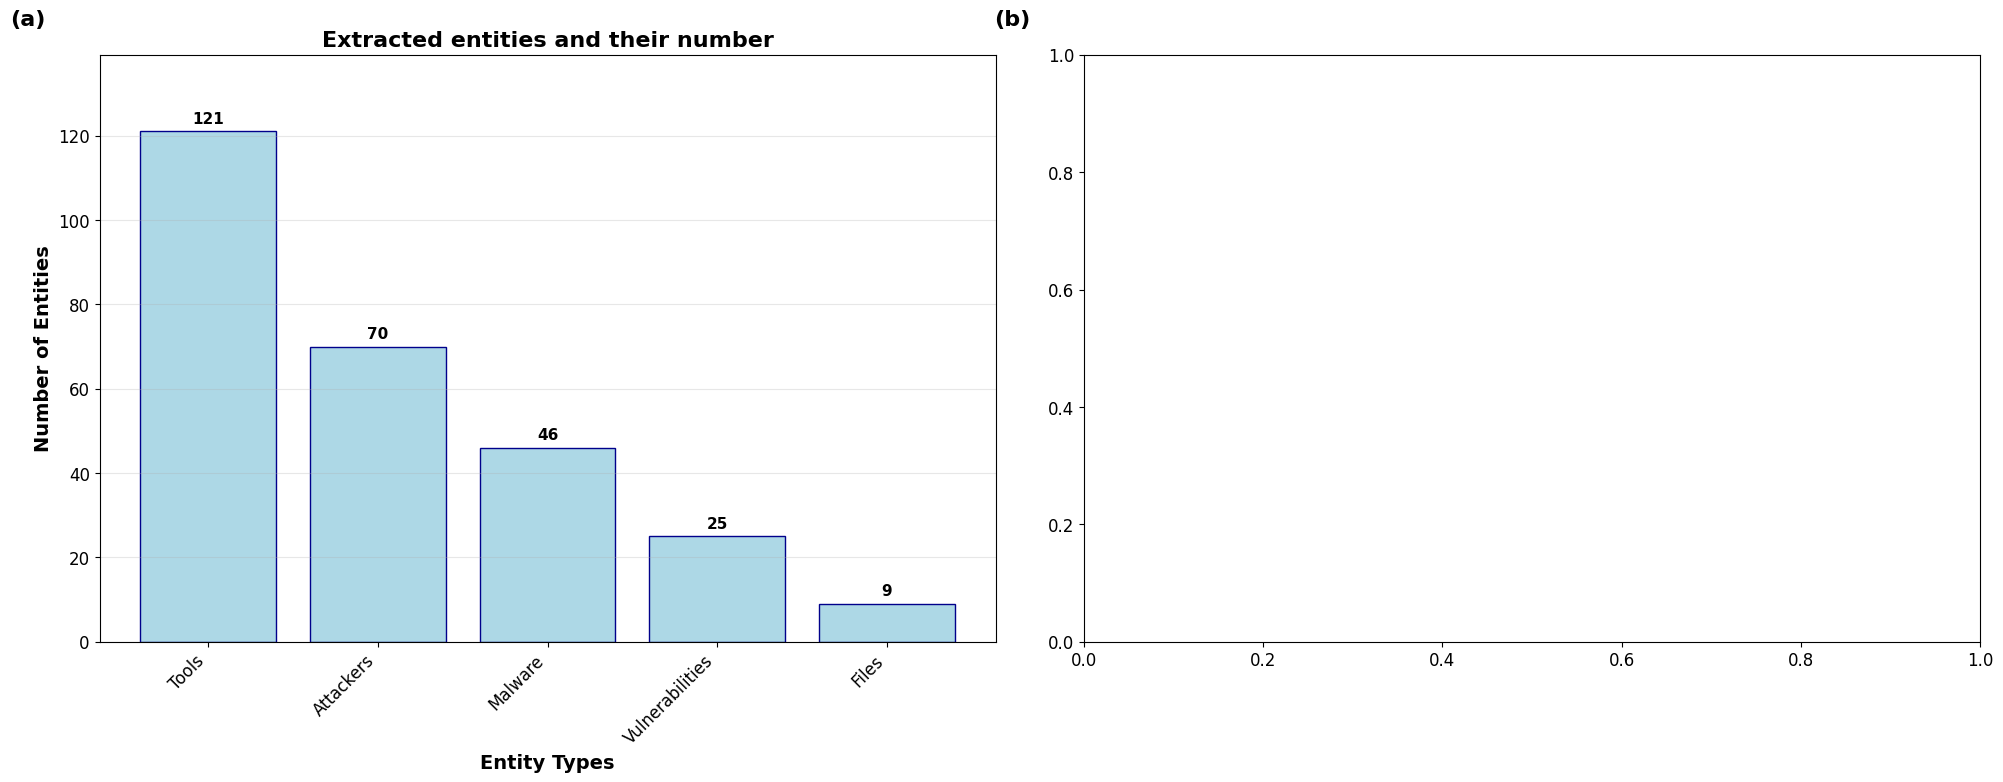


📊 VISUALIZATION STATISTICS:
Total entities plotted: 271
Entity types: 5


In [11]:
# Create publication-quality plots similar to Figure 4.4
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Left plot: Extracted entities and their number
if entity_dataframes:
    entity_counts = {name: len(df) for name, df in entity_dataframes.items()}
    
    # Sort by count (descending)
    sorted_entities = sorted(entity_counts.items(), key=lambda x: x[1], reverse=True)
    entity_names, counts = zip(*sorted_entities)
    
    # Create bar plot with light blue color
    bars1 = ax1.bar(range(len(entity_names)), counts, color='lightblue', edgecolor='darkblue', linewidth=1)
    
    # Customize the plot
    ax1.set_xlabel('Entity Types', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Number of Entities', fontsize=14, fontweight='bold')
    ax1.set_title('Extracted entities and their number', fontsize=16, fontweight='bold')
    ax1.set_xticks(range(len(entity_names)))
    ax1.set_xticklabels([name.replace('_', ' ').title() for name in entity_names], 
                        rotation=45, ha='right', fontsize=12)
    
    # Add value labels on top of bars
    for i, (bar, count) in enumerate(zip(bars1, counts)):
        ax1.text(i, count + max(counts) * 0.01, f'{count}', 
                ha='center', va='bottom', fontweight='bold', fontsize=11)
    
    # Set y-axis limits
    ax1.set_ylim(0, max(counts) * 1.15)
    ax1.grid(True, alpha=0.3, axis='y')

# Right plot: Extracted relationships and their number
if 'relationships_df' in locals():
    relation_counts = relationships_df['relation'].value_counts()
    
    # Get top 15 relationships
    top_relations = relation_counts.head(15)
    relation_names = list(top_relations.index)
    relation_values = list(top_relations.values)
    
    # Create bar plot with light orange/yellow color
    bars2 = ax2.bar(range(len(relation_names)), relation_values, 
                    color='moccasin', edgecolor='darkorange', linewidth=1)
    
    # Customize the plot
    ax2.set_xlabel('Relationship Types', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Number of Relationships', fontsize=14, fontweight='bold')
    ax2.set_title('Extracted relationships and their number', fontsize=16, fontweight='bold')
    ax2.set_xticks(range(len(relation_names)))
    ax2.set_xticklabels(relation_names, rotation=45, ha='right', fontsize=12)
    
    # Add value labels on top of bars
    for i, (bar, count) in enumerate(zip(bars2, relation_values)):
        ax2.text(i, count + max(relation_values) * 0.01, f'{count}', 
                ha='center', va='bottom', fontweight='bold', fontsize=11)
    
    # Set y-axis limits
    ax2.set_ylim(0, max(relation_values) * 1.15)
    ax2.grid(True, alpha=0.3, axis='y')

# Add subplot labels (a) and (b)
ax1.text(-0.1, 1.05, '(a)', transform=ax1.transAxes, fontsize=16, fontweight='bold')
ax2.text(-0.1, 1.05, '(b)', transform=ax2.transAxes, fontsize=16, fontweight='bold')

# Adjust layout
plt.tight_layout()
plt.show()

# Print statistics for the plots
print(f"\n📊 VISUALIZATION STATISTICS:")
if entity_dataframes:
    total_entities = sum(len(df) for df in entity_dataframes.values())
    print(f"Total entities plotted: {total_entities:,}")
    print(f"Entity types: {len(entity_dataframes)}")

if 'relationships_df' in locals():
    total_relationships = len(relationships_df)
    unique_relation_types = relationships_df['relation'].nunique()
    print(f"Total relationships: {total_relationships:,}")
    print(f"Unique relationship types: {unique_relation_types}")
    print(f"Top relationships plotted: {min(15, unique_relation_types)}")


## 6. Data Quality Analysis


In [12]:
# Analyze data quality metrics
print("\n🔍 DATA QUALITY ANALYSIS")
print("=" * 40)

# Entity name quality
if entity_dataframes:
    print("\n📝 ENTITY NAME QUALITY:")
    
    quality_data = []
    for entity_type, df in entity_dataframes.items():
        if 'name' in df.columns:
            total_entities = len(df)
            empty_names = df['name'].isnull().sum() + (df['name'] == '').sum()
            unique_names = df['name'].nunique()
            avg_name_length = df['name'].str.len().mean()
            
            quality_data.append({
                'Entity Type': entity_type.title(),
                'Total': total_entities,
                'Empty Names': f"{empty_names} ({empty_names/total_entities*100:.1f}%)",
                'Unique Names': f"{unique_names} ({unique_names/total_entities*100:.1f}%)",
                'Avg Length': f"{avg_name_length:.1f} chars"
            })
    
    quality_df = pd.DataFrame(quality_data)
    print(quality_df.to_string(index=False))

# Relationship quality
if 'relationships_df' in locals():
    print("\n\n🔗 RELATIONSHIP QUALITY:")
    
    total_relationships = len(relationships_df)
    empty_relations = relationships_df['relation'].isnull().sum() + (relationships_df['relation'] == '').sum()
    unique_relations = relationships_df['relation'].nunique()
    
    print(f"  Total relationships: {total_relationships:,}")
    print(f"  Empty relation types: {empty_relations} ({empty_relations/total_relationships*100:.1f}%)")
    print(f"  Unique relation types: {unique_relations}")
    
    # Check for circular relationships
    circular = relationships_df[relationships_df['source_id'] == relationships_df['target_id']]
    print(f"  Circular relationships: {len(circular)} ({len(circular)/total_relationships*100:.1f}%)")
    
    # Most common relationship patterns
    print(f"\n  📈 Top 5 Relationship Types:")
    top_5_relations = relationships_df['relation'].value_counts().head(5)
    for i, (relation, count) in enumerate(top_5_relations.items(), 1):
        percentage = (count / total_relationships) * 100
        print(f"    {i}. {relation}: {count:,} ({percentage:.1f}%)")



🔍 DATA QUALITY ANALYSIS

📝 ENTITY NAME QUALITY:
    Entity Type  Total Empty Names Unique Names Avg Length
      Attackers     70    0 (0.0%)  70 (100.0%)  9.4 chars
        Malware     46    0 (0.0%)  46 (100.0%)  9.3 chars
          Tools    121    0 (0.0%) 121 (100.0%) 10.8 chars
Vulnerabilities     25    0 (0.0%)  25 (100.0%) 13.3 chars
          Files      9    0 (0.0%)   9 (100.0%) 15.1 chars


## 7. Export Statistics Summary


In [13]:
# Create summary statistics for export
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
summary_file = f"../data/extraction_statistics_summary_{timestamp}.json"

summary_stats = {
    'timestamp': timestamp,
    'processed_entities': {},
    'relationships': {},
    'model_performance': {},
    'data_quality': {}
}

# Add processed entities stats
if entity_dataframes:
    for entity_type, df in entity_dataframes.items():
        summary_stats['processed_entities'][entity_type] = {
            'total_count': len(df),
            'unique_names': df['name'].nunique() if 'name' in df.columns else 0
        }

# Add relationships stats
if 'relationships_df' in locals():
    summary_stats['relationships'] = {
        'total_count': len(relationships_df),
        'unique_types': relationships_df['relation'].nunique(),
        'top_types': dict(relationships_df['relation'].value_counts().head(10))
    }

# Add model performance
for model_name, stats in model_entity_stats.items():
    summary_stats['model_performance'][model_name] = {
        'total_entities': sum(stats.values()),
        'unique_types': len(stats),
        'top_entities': dict(stats.most_common(5))
    }

# Save summary
try:
    with open(summary_file, 'w', encoding='utf-8') as f:
        json.dump(summary_stats, f, indent=2, ensure_ascii=False)
    print(f"\n💾 Statistics summary saved to: {summary_file}")
except Exception as e:
    print(f"❌ Error saving summary: {e}")

# Display final summary
print("\n✨ FINAL SUMMARY")
print("=" * 20)

total_entities = sum(len(df) for df in entity_dataframes.values()) if entity_dataframes else 0
total_relationships = len(relationships_df) if 'relationships_df' in locals() else 0
total_models = len(model_entity_stats)

print(f"📊 Total Processed Entities: {total_entities:,}")
print(f"🔗 Total Relationships: {total_relationships:,}")
print(f"🤖 Models Analyzed: {total_models}")
print(f"📁 Entity Types: {len(entity_dataframes) if entity_dataframes else 0}")

if total_entities > 0 and total_relationships > 0:
    print(f"📈 Entity-to-Relationship Ratio: {total_relationships/total_entities:.2f}")

print(f"\n🕒 Analysis completed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")



💾 Statistics summary saved to: ../data/extraction_statistics_summary_20250831_105505.json

✨ FINAL SUMMARY
📊 Total Processed Entities: 271
🔗 Total Relationships: 0
🤖 Models Analyzed: 2
📁 Entity Types: 5

🕒 Analysis completed at: 2025-08-31 10:55:05


## 2. Entity Statistics Analysis


In [14]:
def extract_entities_from_data(data, model_name):
    """Extract entities from raw extraction data"""
    entity_counts = Counter()
    all_entities = []
    
    for record in data:
        if 'extraction' in record and 'entities' in record['extraction']:
            entities = record['extraction']['entities']
            
            # Handle different entity formats
            if isinstance(entities, list):
                for entity in entities:
                    if isinstance(entity, dict) and 'type' in entity:
                        entity_type = entity['type'].lower()
                        entity_counts[entity_type] += 1
                        all_entities.append({
                            'name': entity.get('name', ''),
                            'type': entity_type,
                            'model': model_name
                        })
    
    return entity_counts, all_entities

# Extract entities for each model
model_entity_stats = {}
all_extracted_entities = []

for model_name, data in extraction_data.items():
    if data:
        entity_counts, entities = extract_entities_from_data(data, model_name)
        model_entity_stats[model_name] = entity_counts
        all_extracted_entities.extend(entities)
        
        print(f"\n📊 {model_name.upper()} Entity Statistics:")
        for entity_type, count in entity_counts.most_common(10):
            print(f"  {entity_type}: {count:,}")

# Create DataFrame for all extracted entities
entities_df = pd.DataFrame(all_extracted_entities)



📊 LLAMA3 Entity Statistics:
  vendor: 256
  threatactor: 212
  malware: 178
  platform: 172
  tool: 134
  geographiclocation: 107
  cve: 66
  technique: 48
  file: 23
  infrastructure: 23

📊 QWEN3_14B Entity Statistics:


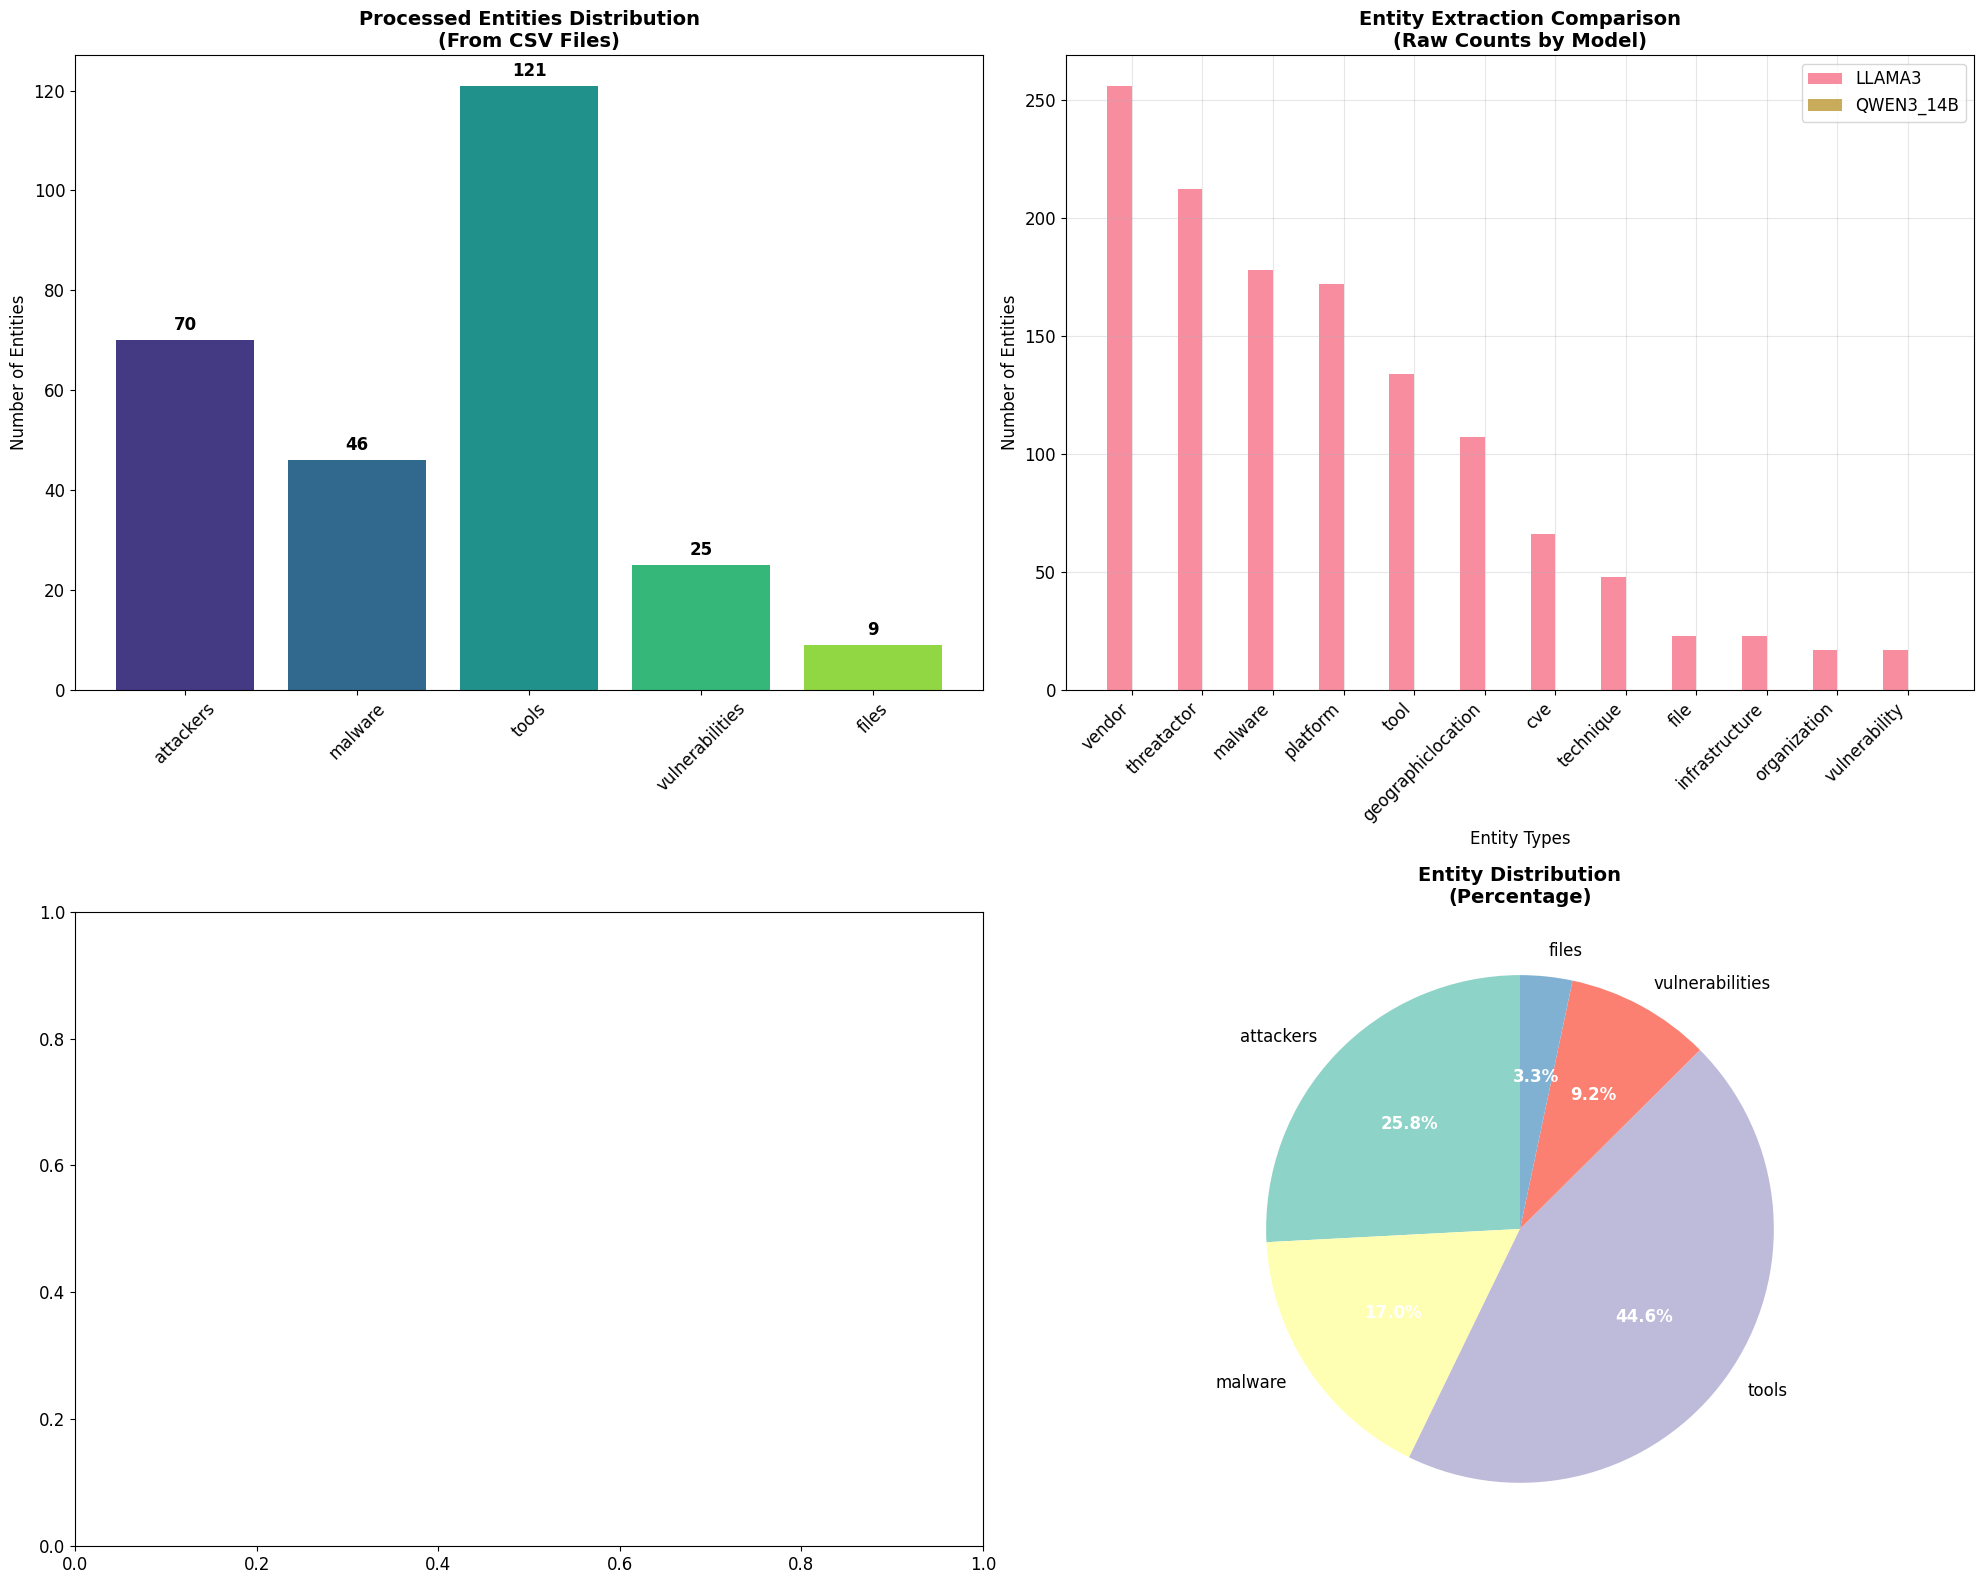

In [15]:
# Plot extracted entities distribution
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# 1. Entity counts from processed CSVs
if entity_dataframes:
    processed_counts = {name: len(df) for name, df in entity_dataframes.items()}
    
    ax1 = axes[0, 0]
    entity_types = list(processed_counts.keys())
    counts = list(processed_counts.values())
    
    bars1 = ax1.bar(entity_types, counts, color=sns.color_palette("viridis", len(entity_types)))
    ax1.set_title('Processed Entities Distribution\n(From CSV Files)', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Number of Entities')
    ax1.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, count in zip(bars1, counts):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(counts)*0.01,
                f'{count:,}', ha='center', va='bottom', fontweight='bold')

# 2. Raw extraction comparison between models
if model_entity_stats:
    ax2 = axes[0, 1]
    
    # Get top entity types across all models
    all_types = set()
    for stats in model_entity_stats.values():
        all_types.update(stats.keys())
    
    top_types = sorted(all_types, 
                      key=lambda x: sum(stats.get(x, 0) for stats in model_entity_stats.values()),
                      reverse=True)[:12]
    
    x = np.arange(len(top_types))
    width = 0.35
    
    for i, (model_name, stats) in enumerate(model_entity_stats.items()):
        values = [stats.get(entity_type, 0) for entity_type in top_types]
        ax2.bar(x + i*width, values, width, label=model_name.upper(), alpha=0.8)
    
    ax2.set_title('Entity Extraction Comparison\n(Raw Counts by Model)', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Number of Entities')
    ax2.set_xlabel('Entity Types')
    ax2.set_xticks(x + width/2)
    ax2.set_xticklabels(top_types, rotation=45, ha='right')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

# 3. Relationship distribution
if 'relationships_df' in locals():
    ax3 = axes[1, 0]
    
    relation_counts = relationships_df['relation'].value_counts().head(15)
    
    bars3 = ax3.barh(range(len(relation_counts)), relation_counts.values,
                     color=sns.color_palette("plasma", len(relation_counts)))
    ax3.set_yticks(range(len(relation_counts)))
    ax3.set_yticklabels(relation_counts.index)
    ax3.set_title('Top Relationship Types\n(From Processed Data)', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Number of Relationships')
    
    # Add value labels
    for i, (bar, count) in enumerate(zip(bars3, relation_counts.values)):
        ax3.text(bar.get_width() + max(relation_counts.values)*0.01, bar.get_y() + bar.get_height()/2,
                f'{count}', ha='left', va='center', fontweight='bold')

# 4. Entity type diversity pie chart
if entity_dataframes:
    ax4 = axes[1, 1]
    
    sizes = list(processed_counts.values())
    labels = list(processed_counts.keys())
    colors = sns.color_palette("Set3", len(labels))
    
    wedges, texts, autotexts = ax4.pie(sizes, labels=labels, autopct='%1.1f%%',
                                       colors=colors, startangle=90)
    ax4.set_title('Entity Distribution\n(Percentage)', fontsize=14, fontweight='bold')
    
    # Make percentage text bold
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')

plt.tight_layout()
plt.show()


## 3. Detailed Statistics Tables
